In [19]:
import os
import sunau
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import librosa
import librosa.display as display

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition as decomp
from sklearn.model_selection import train_test_split as ms_train_test_split
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D

In [21]:
def transform_mfcc(music_file_path):
    y, sr = librosa.core.load(music_file_path)
    return librosa.feature.mfcc(y=y, sr=sr)

def transform_spec(music_file_path):
    y, sr = librosa.core.load(music_file_path)
    return librosa.feature.melspectrogram(y=y, sr=sr)

mfcc_feature = transform_mfcc('/content/CS229-Music-Classification/genres/rock/rock.00005.au')
spectrogram = transform_spec('/content/CS229-Music-Classification/genres/rock/rock.00005.au')

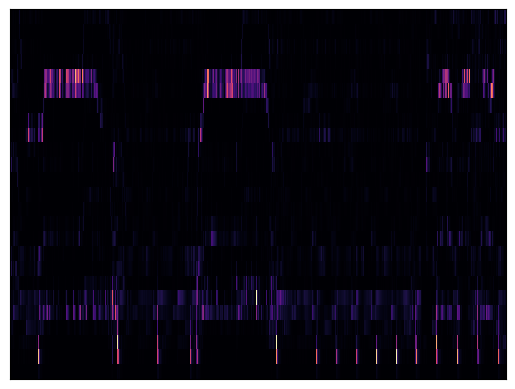

In [22]:
display.specshow(spectrogram[:25])


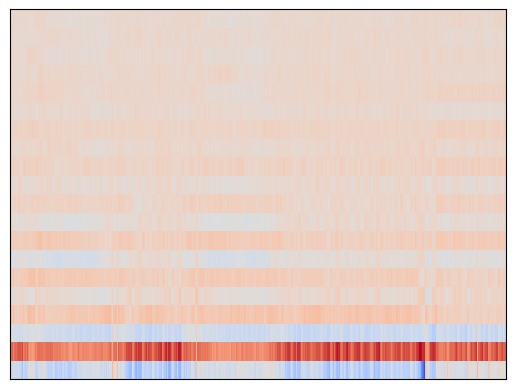

In [23]:
display.specshow(mfcc_feature)

In [24]:
def transform_musics(directory_path):
    """ takes in a directory and return a 3D numpy array where each element is a 2D array of mfcc features.
    """
    result = []
    for root, dirs, files in os.walk (directory_path):
        for file_name in files:
            file_path = root + file_name
            result += [transform_mfcc(file_path)[:20, :1290]]
    len_set = set(music.shape for music in result)
    if len(len_set) > 1:
        print("More than 1 length of music returned {0}".format(len_set))
    return np.array(result)

rocks = transform_musics('/content/CS229-Music-Classification/genres/rock/')

In [25]:
print(rocks.shape)

(100, 20, 1290)


In [26]:
# Check what's actually in the directory
directory_path = '/content/CS229-Music-Classification/genres/rock/'

print(f"Checking directory: {directory_path}")
print(f"Directory exists: {os.path.exists(directory_path)}")
print()

# List everything in the directory
print("Contents:")
for root, dirs, files in os.walk(directory_path):
    print(f"  Root: {root}")
    print(f"  Subdirs: {dirs}")
    print(f"  Files: {files}")
    print(f"  Number of files: {len(files)}")
    print()

# Also check the parent directory
parent = '/content/CS229-Music-Classification/genres/'
print(f"Parent directory ({parent}):")
print(os.listdir(parent))

Checking directory: /content/CS229-Music-Classification/genres/rock/
Directory exists: True

Contents:
  Root: /content/CS229-Music-Classification/genres/rock/
  Subdirs: []
  Files: ['rock.00007.au', 'rock.00043.au', 'rock.00045.au', 'rock.00077.au', 'rock.00006.au', 'rock.00095.au', 'rock.00051.au', 'rock.00098.au', 'rock.00040.au', 'rock.00062.au', 'rock.00013.au', 'rock.00068.au', 'rock.00081.au', 'rock.00094.au', 'rock.00058.au', 'rock.00056.au', 'rock.00063.au', 'rock.00003.au', 'rock.00025.au', 'rock.00071.au', 'rock.00099.au', 'rock.00097.au', 'rock.00008.au', 'rock.00055.au', 'rock.00048.au', 'rock.00096.au', 'rock.00050.au', 'rock.00076.au', 'rock.00031.au', 'rock.00028.au', 'rock.00010.au', 'rock.00065.au', 'rock.00046.au', 'rock.00075.au', 'rock.00073.au', 'rock.00069.au', 'rock.00011.au', 'rock.00085.au', 'rock.00082.au', 'rock.00032.au', 'rock.00022.au', 'rock.00019.au', 'rock.00070.au', 'rock.00035.au', 'rock.00091.au', 'rock.00088.au', 'rock.00024.au', 'rock.00034.au', 

In [27]:
# Test transform_musics with full path
print("Testing transform_musics with full path:")
rocks = transform_musics('/content/CS229-Music-Classification/genres/rock/')
print(f"Rocks shape: {rocks.shape}")
print(f"Rocks dtype: {rocks.dtype}")
print()

# Also test the blues directory
print("Testing blues:")
blues = transform_musics('/content/CS229-Music-Classification/genres/blues/')
print(f"Blues shape: {blues.shape}")
print()

# Now test process_all with full paths
def process_all(directory_path):
    sub_dirs = os.listdir('/content/CS229-Music-Classification/genres/')
    c = 5
    X = np.empty((0, 20, 1290))
    Y = np.empty((0, c))
    j = 0
    for i in range(len(sub_dirs)):
        print('processing genre {0}'.format(sub_dirs[i]))
        if sub_dirs[i] in ['classical', 'hiphop', 'metal', 'pop', 'blues']:
            # Use full path here
            full_path = f'/content/CS229-Music-Classification/genres/{sub_dirs[i]}/'
            X_is = transform_musics(full_path)
            print(f"  X_is shape: {X_is.shape}")

            if X_is.shape[0] > 0:  # Only concatenate if not empty
                X = np.concatenate((X, X_is), axis=0)
                Y_is = np.zeros((X_is.shape[0], c))
                Y_is[:, j] = 1
                Y = np.concatenate((Y, Y_is), axis=0)
                j += 1

    return X, Y

X, Y = process_all('/content/CS229-Music-Classification/genres/')
print(f"\nFinal X shape: {X.shape}")
print(f"Final Y shape: {Y.shape}")

Testing transform_musics with full path:
Rocks shape: (100, 20, 1290)
Rocks dtype: float32

Testing blues:
Blues shape: (100, 20, 1290)

processing genre country
processing genre rock
processing genre reggae
processing genre jazz
processing genre disco
processing genre hiphop
  X_is shape: (100, 20, 1290)
processing genre blues
  X_is shape: (100, 20, 1290)
processing genre metal
  X_is shape: (100, 20, 1290)
processing genre pop
  X_is shape: (100, 20, 1290)
processing genre classical
  X_is shape: (100, 20, 1290)

Final X shape: (500, 20, 1290)
Final Y shape: (500, 5)


In [28]:
import os

# Check if the directory exists
directory = '/content/data_mat/'
print(f"Directory exists: {os.path.exists(directory)}")

if not os.path.exists(directory):
    print(f"Creating directory: {directory}")
    os.makedirs(directory)

# Now try saving
np.save('/content/data_mat/X3.npy', X)
np.save('/content/data_mat/Y3.npy', Y)
print("Files saved successfully!")

# Verify they were saved
print(f"\nX3.npy exists: {os.path.exists('/content/data_mat/X3.npy')}")
print(f"Y3.npy exists: {os.path.exists('/content/data_mat/Y3.npy')}")

Directory exists: True
Files saved successfully!

X3.npy exists: True
Y3.npy exists: True


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [30]:
X = np.load('data_mat/X3.npy')
Y = np.load('data_mat/Y3.npy')


In [31]:
print("training X shape is {0}".format(X.shape))
print("training Y shape is {0}".format(Y.shape))


training X shape is (500, 20, 1290)
training Y shape is (500, 5)


Text(0.5, 1.0, 'Metal MFCC feature heat map')

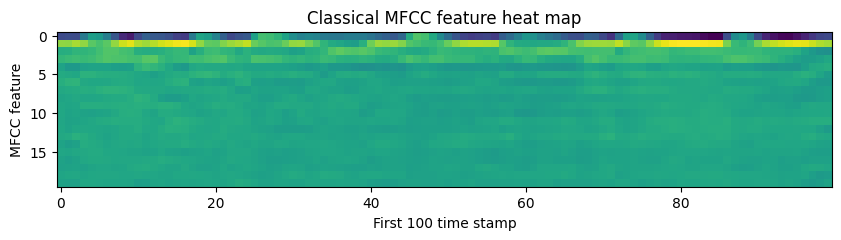

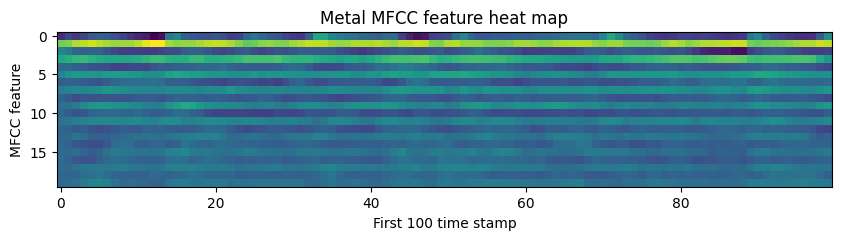

In [32]:
plt.figure(figsize=(10, 4))
plt.imshow(X[0][:, :100])
plt.xlabel('First 100 time stamp')
plt.ylabel('MFCC feature')
plt.title('Classical MFCC feature heat map')
# plt.savefig('plots/classical_mfcc.png')

plt.figure(figsize=(10, 4))
plt.imshow(X[200][:, :100])
plt.xlabel('First 100 time stamp')
plt.ylabel('MFCC feature')
plt.title('Metal MFCC feature heat map')
# plt.savefig('plots/metal_mfcc.png')


In [33]:
inds = np.arange(X.shape[0])
np.random.shuffle(inds)
X_train, X_test, Y_train, Y_test = ms_train_test_split(
    X[inds], Y[inds], test_size=0.2, random_state=123
)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



(400, 20, 1290) (100, 20, 1290) (400, 5) (100, 5)


In [35]:
X_train_t = torch.FloatTensor(X_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
Y_train_t = torch.FloatTensor(Y_train).to(device)
Y_test_t = torch.FloatTensor(Y_test).to(device)



In [36]:
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [37]:
class DCNNModel(nn.Module):
    def __init__(self, input_channels=20, num_classes=5):
        super(DCNNModel, self).__init__()

        # First DCNN unit
        self.conv1 = nn.Conv1d(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=64,
            dilation=8,
            padding=252
        )
        self.dropout1 = nn.Dropout(0.5)
        self.pool1 = nn.AvgPool1d(kernel_size=32)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.ReLU()

        # Second DCNN unit
        self.conv2 = nn.Conv1d(
            in_channels=16,
            out_channels=64,
            kernel_size=16,
            dilation=2,
            padding=0
        )
        self.dropout2 = nn.Dropout(0.5)
        self.pool2 = nn.AvgPool1d(kernel_size=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()

        # Fully connected layer
        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.dropout2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.flatten(x)
        x = self.dropout3(x)
        x = self.fc(x)

        return x

m = DCNNModel(input_channels=20, num_classes=5).to(device)


In [38]:
import os
os.makedirs('extracted', exist_ok=True)

In [39]:
print("\nModel Summary:")
print(m)
total_params = sum(p.numel() for p in m.parameters())
trainable_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params
print(f"\nTotal params: {total_params}")
print(f"Trainable params: {trainable_params}")
print(f"Non-trainable params: {non_trainable}")



Model Summary:
DCNNModel(
  (conv1): Conv1d(20, 16, kernel_size=(64,), stride=(1,), padding=(252,), dilation=(8,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (pool1): AvgPool1d(kernel_size=(32,), stride=(32,), padding=(0,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv1d(16, 64, kernel_size=(16,), stride=(1,), dilation=(2,))
  (dropout2): Dropout(p=0.5, inplace=False)
  (pool2): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

Total params: 37749
Trainable params: 37749
Non-trainable params: 0


In [40]:
# Clear only the model-related variables
if 'm' in locals():
    del m
if 'optimizer' in locals():
    del optimizer
if 'train_loader' in locals():
    del train_loader
if 'test_loader' in locals():
    del test_loader

# Clear GPU memory if using it
import gc
gc.collect()
torch.cuda.empty_cache()

# Now reinitialize and train fresh
m = DCNNModel(input_channels=20, num_classes=5).to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Then run your training loop

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999))

num_epochs = 50
print("\nTraining:")
for epoch in range(num_epochs):
    m.train()
    epoch_loss = 0
    correct = 0
    total = 0
    batch_count = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = m(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(batch_y, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    avg_acc = correct / total

    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - loss: {avg_loss:.4f} - categorical_accuracy: {avg_acc:.4f}")



Training:
Epoch 1/50 - loss: 1.3845 - categorical_accuracy: 0.3975
Epoch 2/50 - loss: 1.1025 - categorical_accuracy: 0.5975
Epoch 3/50 - loss: 0.9201 - categorical_accuracy: 0.6700
Epoch 4/50 - loss: 0.8169 - categorical_accuracy: 0.7075
Epoch 5/50 - loss: 0.6911 - categorical_accuracy: 0.7750
Epoch 6/50 - loss: 0.6174 - categorical_accuracy: 0.8100
Epoch 7/50 - loss: 0.6105 - categorical_accuracy: 0.8125
Epoch 8/50 - loss: 0.5460 - categorical_accuracy: 0.8300
Epoch 9/50 - loss: 0.5302 - categorical_accuracy: 0.8475
Epoch 10/50 - loss: 0.5391 - categorical_accuracy: 0.8600
Epoch 11/50 - loss: 0.4358 - categorical_accuracy: 0.8475
Epoch 12/50 - loss: 0.4323 - categorical_accuracy: 0.8750
Epoch 13/50 - loss: 0.4515 - categorical_accuracy: 0.8825
Epoch 14/50 - loss: 0.3993 - categorical_accuracy: 0.8600
Epoch 15/50 - loss: 0.3874 - categorical_accuracy: 0.8800
Epoch 16/50 - loss: 0.3893 - categorical_accuracy: 0.8825
Epoch 17/50 - loss: 0.3637 - categorical_accuracy: 0.8725
Epoch 18/50 


Train Evaluation:
Loss = 0.0897548816033772
Train Accuracy = 0.9775

Test Evaluation:
Loss = 0.4024815410375595
Test Accuracy = 0.82


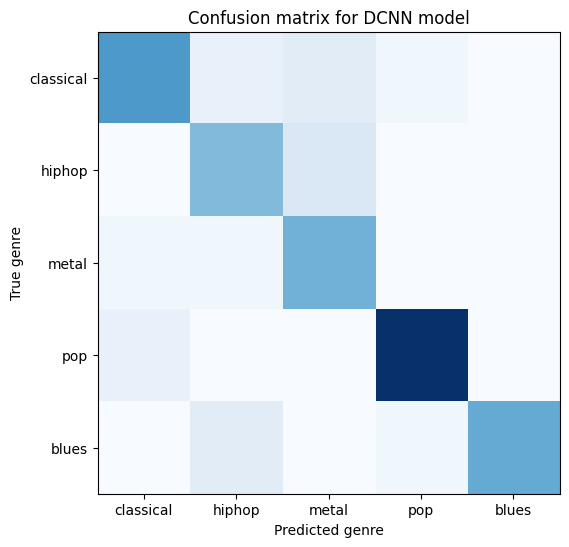

In [42]:
def evaluate_model(model, loader, data_type="Train"):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    batch_count = 0

    with torch.no_grad():
        for batch_x, batch_y in loader:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            batch_count += 1

            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(batch_y, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / batch_count
    avg_acc = correct / total

    print(f"Loss = {avg_loss}")
    print(f"{data_type} Accuracy = {avg_acc}")

    return np.concatenate(all_preds), np.concatenate(all_labels)

print("\nTrain Evaluation:")
train_preds, train_labels = evaluate_model(m, train_loader, "Train")

print("\nTest Evaluation:")
test_preds, test_labels = evaluate_model(m, test_loader, "Test")

# Confusion matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(test_labels, test_preds)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.xticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.yticks(list(range(5)), ['classical', 'hiphop', 'metal', 'pop', 'blues'])
plt.title('Confusion matrix for DCNN model')
plt.xlabel('Predicted genre')
plt.ylabel('True genre')
# plt.savefig('plots/dcnn_confusion.png')
plt.show()



In [43]:
print("\n" + "="*80)
print("Feature Extraction")
print("="*80)

def extract_all_features(model, loader, layer_names):
    """Extract features from specified layers"""
    model.eval()
    features_dict = {name: [] for name in layer_names}

    layer_outputs = {}

    def get_hook(name):
        def hook(module, input, output):
            layer_outputs[name] = output.detach().cpu()
        return hook

    hooks = []
    for name, module in model.named_modules():
        if name in layer_names:
            hooks.append(module.register_forward_hook(get_hook(name)))

    with torch.no_grad():
        for batch_x, _ in loader:
            model(batch_x)
            for name in layer_names:
                if name in layer_outputs:
                    output = layer_outputs[name]
                    if output.dim() > 2:
                        output = output.reshape(output.size(0), -1)
                    features_dict[name].append(output)

    for hook in hooks:
        hook.remove()

    for name in layer_names:
        features_dict[name] = torch.cat(features_dict[name], dim=0).numpy()

    return features_dict



Feature Extraction


In [49]:
print("Extracting features from best model...")
train_features = extract_all_features(m, train_loader, ['relu1', 'relu2'])
test_features = extract_all_features(m, test_loader, ['relu1', 'relu2'])

conv_1_train = train_features['relu1']
conv_1_test = test_features['relu1']
conv_2_train = train_features['relu2']
conv_2_test = test_features['relu2']

print(f"conv_1_train shape: {conv_1_train.shape}")
print(f"conv_1_test shape: {conv_1_test.shape}")
print(f"conv_2_train shape: {conv_2_train.shape}")
print(f"conv_2_test shape: {conv_2_test.shape}")

np.savetxt('extracted/conv_1_train.txt', conv_1_train)
np.savetxt('extracted/conv_2_train.txt', conv_2_train)
np.savetxt('extracted/conv_1_test.txt', conv_1_test)
np.savetxt('extracted/conv_2_test.txt', conv_2_test)


Extracting features from best model...
conv_1_train shape: (400, 640)
conv_1_test shape: (100, 640)
conv_2_train shape: (400, 128)
conv_2_test shape: (100, 128)


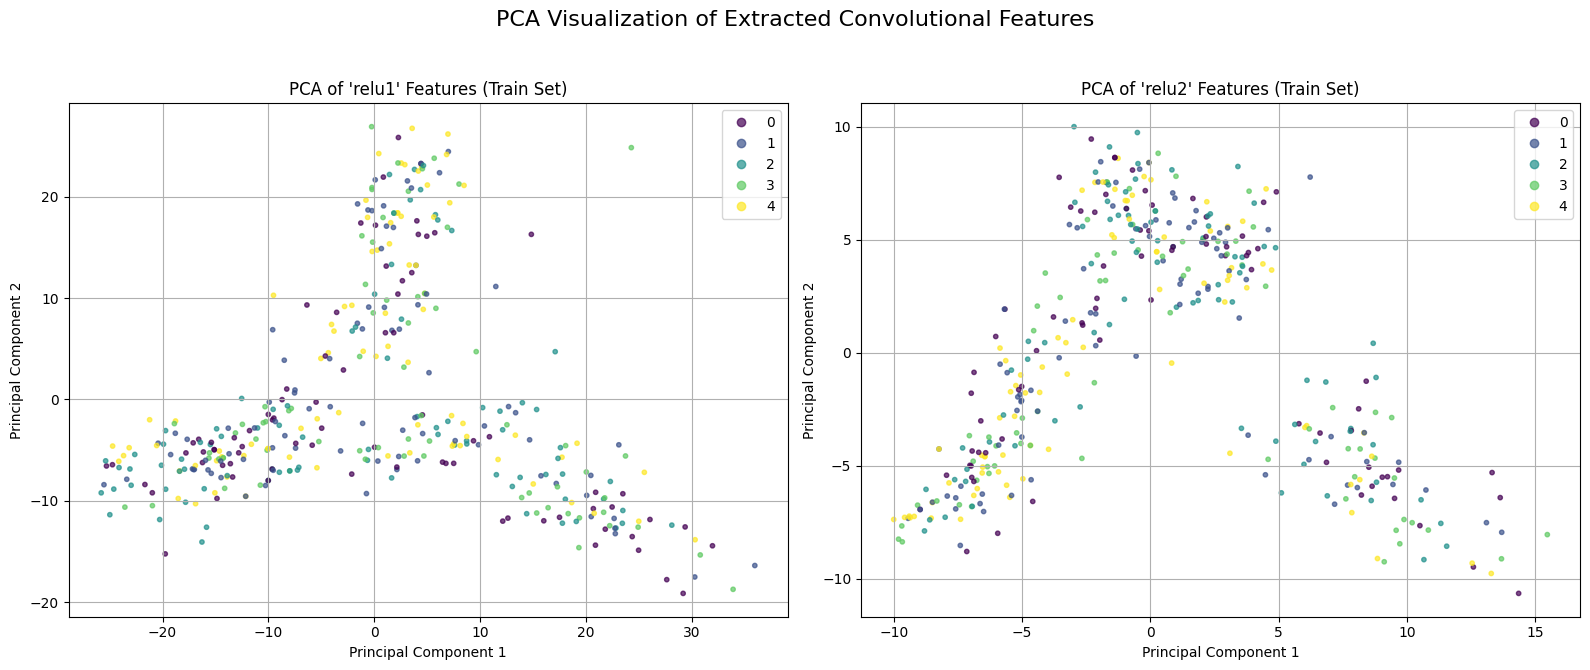

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

conv_1_train = np.loadtxt('extracted/conv_1_train.txt')
conv_2_train = np.loadtxt('extracted/conv_2_train.txt')
scaler = StandardScaler()
conv_1_train_scaled = scaler.fit_transform(conv_1_train)
conv_2_train_scaled = scaler.fit_transform(conv_2_train)

pca_conv1 = PCA(n_components=2)
conv_1_train_pca = pca_conv1.fit_transform(conv_1_train_scaled)

pca_conv2 = PCA(n_components=2)
conv_2_train_pca = pca_conv2.fit_transform(conv_2_train_scaled)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
scatter1 = plt.scatter(conv_1_train_pca[:, 0], conv_1_train_pca[:, 1], c=train_labels, cmap='viridis', alpha=0.7, s=10)
plt.title("PCA of 'relu1' Features (Train Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles=scatter1.legend_elements()[0], labels=sorted(list(set(train_labels))))
plt.grid(True)

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(conv_2_train_pca[:, 0], conv_2_train_pca[:, 1], c=train_labels, cmap='viridis', alpha=0.7, s=10)
plt.title("PCA of 'relu2' Features (Train Set)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles=scatter2.legend_elements()[0], labels=sorted(list(set(train_labels))))
plt.grid(True)

plt.suptitle('PCA Visualization of Extracted Convolutional Features', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pca_feature_visualization.png')
